# Treinamento e validação de Modelos - Dataset Fake.br-Corpus

In [1]:
import os
import sagemaker
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score
from python_scripts.save_load import load_df_from_bucket, save_df_to_s3_bucket, save_to_s3_bucket_as_libsvm, BUCKET_MODEL
from python_scripts.modelling import create_train_validation_test_sets, setup_model, make_prediction    
from python_scripts.plots import plot_confusion_matrix

## Carregamento de dados
Apenas as colunas de lemmas, tamanho médio de sentença e tamanho médio de palavra serão utilizadas no modelo

In [2]:
full_df = load_df_from_bucket('dados_processados.csv', tipo='processado')
full_df.head()

,fake,text,avg_sent_len,avg_word_len,words_str,lemmas_str
0,0,A divisão do STF ao meio entre partidários e ...,10.504673,6.785107,divisão STF meio partidários independentes fic...,divisão STF meio partidário independente ficar...
1,1,"General manda recado para STF: ""Abaixaram as c...",10.866667,6.502610,General manda recado STF Abaixaram calças Cong...,general mandar recado STF abaixar calça congre...
2,1,O Nordeste acordou! Lula e o PT são enxotados:...,7.333333,6.565873,Nordeste acordou Lula PT enxotados Chega bande...,nordeste acordar Lula PT enxotar chegar bandei...
3,0,"Dois relatórios da Polícia Federal, com análi...",16.878788,7.286668,Dois relatórios Polícia Federal análises mater...,dois relatório Polícia Federal análise materia...
4,1,Coreia do Norte declara status de QUASE-GUERRA...,11.600000,6.531320,Coreia Norte declara status QUASE-GUERRA mobil...,Coreia Norte declarar status QUASE-GUERRA mobi...


In [3]:
model_df = full_df[['fake', 'lemmas_str', 'avg_sent_len', 'avg_word_len']]
model_df.head()

,fake,lemmas_str,avg_sent_len,avg_word_len
0,0,divisão STF meio partidário independente ficar...,10.504673,6.785107
1,1,general mandar recado STF abaixar calça congre...,10.866667,6.502610
2,1,nordeste acordar Lula PT enxotar chegar bandei...,7.333333,6.565873
3,0,dois relatório Polícia Federal análise materia...,16.878788,7.286668
4,1,Coreia Norte declarar status QUASE-GUERRA mobi...,11.600000,6.531320


## Modelo 1: Baseado em tamanho de sentenças e palavras

O primeiro modelo treinado é um modelo mais simples. Aqui, apenas as colunas referentes ao tamanho médio de sentença e de palavra de cada artigo são consideradas, sem se levar em conta  o conteúdo da notícia propriamente dita.

### Separar dados de treino e teste

In [4]:
train_1, test_1, validate_1 = create_train_validation_test_sets(model_df.drop('lemmas_str', axis=1), 
                                                                stratify_col='fake',
                                                                test_size=0.2, random_state=42)

In [5]:
def create_x_y_1(base_df, target_col='fake'):
    return base_df.drop(target_col, axis=1), base_df[target_col]

x_train_1, y_train_1 = create_x_y_1(train_1)
x_validate_1, y_validate_1 = create_x_y_1(validate_1)
x_test_1, y_test_1 = create_x_y_1(test_1)

### Upload de dados para o S3

In [6]:
file_name_tuples = [(x_train_1, y_train_1, 'train'), 
                   (x_test_1, y_test_1, 'test'), 
                   (x_validate_1, y_validate_1, 'validate')]

for x, y, prefix in file_name_tuples:
    save_to_s3_bucket_as_libsvm(x, y, prefix=prefix, filename='model_1.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazon

### Treinar modelo

In [7]:
xgb_model, data_channels = setup_model(base_image='xgboost', model_name='model_1', instance_count=2, 
                                       instance_type='ml.m4.xlarge')
xgb_model.fit(inputs=data_channels)

print('ready for hosting!')

2022-11-16 13:26:17 Starting - Starting the training job...ProfilerReport-1668605177: InProgress
...
2022-11-16 13:28:12 Downloading - Downloading input data......
2022-11-16 13:29:01 Training - Downloading the training image.....[2022-11-16 13:29:57.052 ip-10-0-97-128.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-16:13:29:57:INFO] Imported framework sagemaker_xgboost_container.training
[2022-11-16:13:29:57:INFO] Failed to parse hyperparameter eval_metric value map to Json.
Returning the value itself
[2022-11-16:13:29:57:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-11-16:13:29:57:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-16:13:29:57:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-11-16:13:29:57:INFO] files path: /opt/ml/input/data/train
[2022-11-16:13:29:57:INFO] files path: /opt/ml/input/data/validation
[2022-11-16:13:29:57:INFO] Distributed node training with 

In [8]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                 serializer=sagemaker.serializers.LibSVMSerializer(),
                                 instance_type='ml.m4.xlarge')

--------!

### Métricas no conjunto de testes

In [9]:
y_pred_1 = make_prediction(xgb_predictor, model_name='model_1')

# Alternativa para carregar resultados salvos em outra execução
# from python_scripts.save_load import BUCKET_MODEL
# y_pred_1 = pd.read_csv(f's3://{BUCKET_MODEL}/test/pred_1.csv')

In [10]:
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66       360
           1       0.66      0.66      0.66       360

    accuracy                           0.66       720
   macro avg       0.66      0.66      0.66       720
weighted avg       0.66      0.66      0.66       720



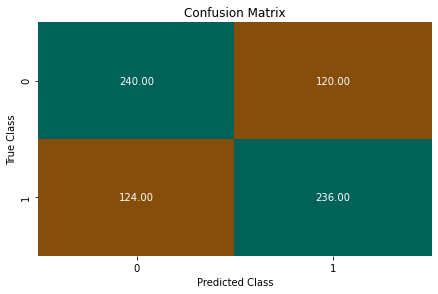

In [11]:
plot_confusion_matrix(y_test_1, y_pred_1)

In [12]:
precision_score(y_test_1, y_pred_1)

0.6629213483146067

Modelo razoável dado sua simplicidade (ignora completamente o contexto)

### Salvar resultados de predição

In [13]:
df_pred_1 = pd.DataFrame({'pred_1': y_pred_1})
df_pred_1.to_csv(f's3://{BUCKET_MODEL}/test/pred_1.csv', encoding='utf-8', index=False)

### Encerrar modelo
Após pegar métricas e dados de interesse, encerrar modelo para evitar cobranças.

In [14]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True) 

## Modelo 2: TF-IDF

In [15]:
train_2, test_2, validate_2 = create_train_validation_test_sets(model_df.drop(['avg_word_len', 
                                                                               'avg_sent_len'], axis=1), 
                                                                stratify_col='fake',
                                                                test_size=0.2, random_state=42)

### Processamento adicional

Um vetorizador TFIDF é utilizado para converter os dados textuais em colunas do DataFrame.

In [16]:
# Criar vetorizador TFIDF e ajustar aos dados de treinamento
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
tfidf.fit(train_2['lemmas_str'])

TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [17]:
def create_x_y_2(base_df, tfidf, target_col='fake', lemma_col = 'lemmas_str'):
    tfidf_res = tfidf.transform(base_df[lemma_col])
    return tfidf_res, base_df[target_col]

x_train_2, y_train_2 = create_x_y_2(train_2, tfidf)
x_validate_2, y_validate_2 = create_x_y_2(validate_2, tfidf)
x_test_2, y_test_2 = create_x_y_2(test_2, tfidf)

### Upload de dados para o S3

In [18]:
file_name_tuples = [(x_train_2, y_train_2, 'train'), 
                   (x_test_2, y_test_2, 'test'), 
                   (x_validate_2, y_validate_2, 'validate')]

for x, y, prefix in file_name_tuples:
    save_to_s3_bucket_as_libsvm(x, y, prefix=prefix, filename='model_2.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazon

### Treinar modelo

In [19]:
xgb_model_2, data_channels_2 = setup_model(base_image='xgboost', model_name='model_2', instance_count=4, 
                                           instance_type='ml.m4.xlarge')
xgb_model_2.fit(inputs=data_channels_2)

print('ready for hosting!')

2022-11-16 13:35:34 Starting - Starting the training job...ProfilerReport-1668605733: InProgress
......
2022-11-16 13:36:57 Starting - Preparing the instances for training.........
2022-11-16 13:38:18 Downloading - Downloading input data...
2022-11-16 13:38:58 Training - Downloading the training image......
2022-11-16 13:40:04 Training - Training image download completed. Training in progress..[2022-11-16 13:40:08.684 ip-10-0-241-114.ec2.internal:10 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-16:13:40:08:INFO] Imported framework sagemaker_xgboost_container.training
[2022-11-16:13:40:08:INFO] Failed to parse hyperparameter eval_metric value map to Json.
Returning the value itself
[2022-11-16:13:40:08:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-11-16:13:40:08:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-16:13:40:08:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-11-16:13:40:08:I

In [20]:
xgb_predictor_2 = xgb_model_2.deploy(initial_instance_count=1,
                                     serializer=sagemaker.serializers.LibSVMSerializer(),
                                     instance_type='ml.m4.xlarge')

-------!

### Métricas do modelo
O conjunto de testes é separado em duas partes para o teste, devido a limitações no tamanho de payload que podem ser enviadas ao endpoint

In [21]:
# Alternativa para carregar resultados salvos em outra execução
# from python_scripts.save_load import BUCKET_MODEL
# y_pred_2 = pd.read_csv(f's3://{BUCKET_MODEL}/test/pred_2.csv')

In [22]:
half = test_2.shape[0]//2
x_test_2_pt1, y_test_2_pt1 = create_x_y_2(test_2.iloc[:half], tfidf)
x_test_2_pt2, y_test_2_pt2 = create_x_y_2(test_2.iloc[half:], tfidf)

In [23]:
save_to_s3_bucket_as_libsvm(x_test_2_pt1, y_test_2_pt1, prefix='test', 
                            filename='model_2_pt1.libsvm', tipo='modelo')
save_to_s3_bucket_as_libsvm(x_test_2_pt2, y_test_2_pt2, prefix='test', 
                            filename='model_2_pt2.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [24]:
import s3fs
from sklearn.datasets import load_svmlight_file

fs = s3fs.S3FileSystem()
s3_path = f's3://projetointerdisciplinartreinoteste/test/model_2_pt1.libsvm'

with fs.open(s3_path) as libsvm_file:
    y_temp_1 = xgb_predictor_2.predict(libsvm_file)


s3_path = f's3://projetointerdisciplinartreinoteste/test/model_2_pt2.libsvm'

with fs.open(s3_path) as libsvm_file:
    y_temp_2 = xgb_predictor_2.predict(libsvm_file)


In [25]:
#Threhold de 0.5 para decidir classes
y_pred_list_1 = [1 if float(x) >= 0.5 else 0 for x in y_temp_1.decode('utf-8').split('\n') if x != '']
y_pred_list_2 = [1 if float(x) >= 0.5 else 0 for x in y_temp_2.decode('utf-8').split('\n') if x != '']

In [26]:
y_pred_2 = y_pred_list_1+y_pred_list_2

In [27]:
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       360
           1       0.94      0.97      0.95       360

    accuracy                           0.95       720
   macro avg       0.95      0.95      0.95       720
weighted avg       0.95      0.95      0.95       720



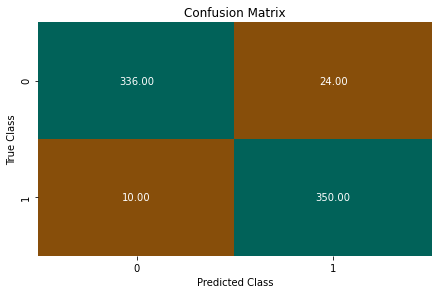

In [28]:
plot_confusion_matrix(y_test_2, y_pred_2)

In [29]:
precision_score(y_test_2, y_pred_2)

0.9358288770053476

Resultados excelentes, muito acima do que seria razoavelmente esperado. Isto sugere problemas de *overfit* no dataset utilizado para a construção do modelo. Para testar a hipótese de *overfit*, posteriormente dados de teste serão amostrados do segundo dataset (FakeRecogna) para uma segunda validação deste modelo.

## Salvar resultados da predição

In [30]:
df_pred_2 = pd.DataFrame({'pred_2': y_pred_2})
df_pred_2.to_csv(f's3://{BUCKET_MODEL}/test/pred_2.csv', encoding='utf-8', index=False)

## Teste adicional - Dataset FakeRecogna
Serão amostradas 3500 notícias do Dataset FakeRecogna para uma segunda validação do presente modelo.

### Carregar dataset e amostrar dados

In [31]:
alternative_df = load_df_from_bucket('dados_processados_recogna.csv', tipo='processado')
alternative_df.head()

,Categoria,lemmas_str,fake
0,entretenimento,apagão vaticano papar presar acusação tráfico ...,1
1,saúde,governar equador anunciar preparar cova coleti...,0
2,saúde,companhia air france operar voar direto pequim...,0
3,saúde,marfrig global foods retomar vender carnar bov...,0
4,entretenimento,assunto voltar compartilhar rede social julho ...,1


In [32]:
sample_df = alternative_df.sample(n=3500, random_state=42)
sample_df.head()

,Categoria,lemmas_str,fake
2473,mundo,dia acordar decretar presidente corresponder s...,1
8153,saúde,comedir problema vacinar proibir voar ditar ap...,1
3154,saúde,olhar beleza poema escrever século indicar pub...,1
668,saúde,turístico rir janeiro decidir manter previsão ...,0
9772,saúde,governar federal anunciar quintafeira dia bras...,0


#### Predição

Aplicar TF-IDF para vetorizar, salvar dados no S3 e efetuar predição

In [33]:
x_test_alt, y_test_alt = create_x_y_2(sample_df, tfidf)
save_to_s3_bucket_as_libsvm(x_test_alt, y_test_alt, 
                            prefix='test', filename='model_2_alt.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [34]:
y_pred_alt = make_prediction(xgb_predictor_2, model_name='model_2_alt')

# Alternativa para carregar resultados salvos em outra execução
# from python_scripts.save_load import BUCKET_MODEL
# y_pred_alt = pd.read_csv(f's3://{BUCKET_MODEL}/test/pred_alt.csv')

#### Métricas

In [35]:
print(classification_report(y_test_alt, y_pred_alt))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1779
           1       0.49      1.00      0.66      1721

    accuracy                           0.49      3500
   macro avg       0.75      0.50      0.33      3500
weighted avg       0.75      0.49      0.32      3500



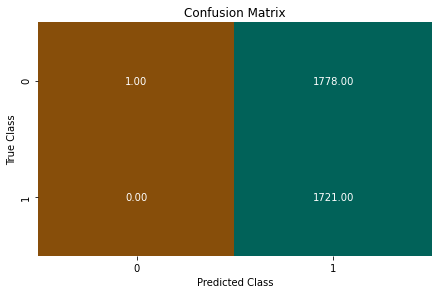

In [36]:
plot_confusion_matrix(y_test_alt, y_pred_alt)

In [37]:
precision_score(y_test_alt, y_pred_alt)

0.4918548156616176

In [38]:
# Proporção de previsões de notícias falsas em y_pred_alt
round(sum(y_pred_alt)/len(y_pred_alt), 4)  # 4 casas para ver que não foi TUDO

0.9997

In [39]:
# Proporção de notícias realmente falsas nos dados de teste
round(sample_df['fake'].sum()/sample_df.shape[0], 2)

0.49

Ao se testar o modelo no dataset FakeRecogna, os resultados obtidos foram muito ruins! O modelo simplesmente previu que praticamente todas as notícias do dataset seriam falsas. Uma hipótese do que pode ter levado a este resultado é a diferença nos termos utilizados nas notícias. O dataset FakeRecogna, por abrangir os anos de 2019 a 2021, apresenta um peso muito grande para termos relativos à pandemia de COVID-19 que se iniciou em 2020, e que não apareciam em grande quantidade no dataset Fake.br-Corpus.

Um modelo treinado baseado no dataset FakeRecogna é apresentado no Notebook `model_fakerecogna.ipynb`, enquanto que um modelo baseado em ambos datasets é apresentado no notebook `model_fakebr.ipynb`.

#### Salvar predição

In [40]:
df_pred_alt = pd.DataFrame({'pred_alt': y_pred_alt})
df_pred_alt.to_csv(f's3://{BUCKET_MODEL}/test/pred_alt.csv', encoding='utf-8', index=False)

### Encerrar modelo
Após pegar métricas e dados de interesse, encerrar modelo para evitar cobranças.

In [41]:
xgb_predictor_2.delete_endpoint(delete_endpoint_config=True) 